In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)
learningRate = 0.0002
batchSize = 32
imageSize = 64
channelsImage = 3  
noiseDim = 100
numEpochs = 25
featuresDisc = 64 
featuresGen = 64 
weightsClip = 0.01
criticItr = 2

Device: cuda


In [3]:
dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


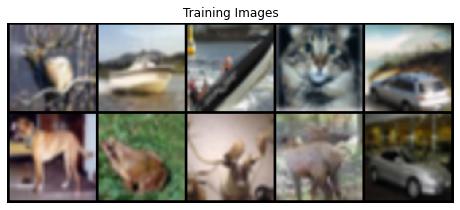

In [4]:
# Plot training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10],nrow=5, padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            
            self.Dnet(features_d, features_d * 2, 4, 2, 1),      
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  
            
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine =True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

#Intitating instances
disc = Discriminator(channelsImage, featuresDisc).to(device)
initialize_weights(disc)

In [7]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            
            self.Gnet(channels_noise, features_g * 16, 4, 1, 0), 
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),  
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),  
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),  
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            
            nn.Tanh(),
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

#Intitating instances
gen = Generator(noiseDim, channelsImage, featuresGen).to(device)
initialize_weights(gen)


In [8]:
optimGenerator = optim.RMSprop(gen.parameters(), lr=learningRate)
optimDiscriminator = optim.RMSprop(disc.parameters(), lr=learningRate)
fixed_noise = torch.randn(batchSize, noiseDim, 1, 1).to(device)
step = 0

In [9]:
gen.train() , disc.train()

(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): C

In [10]:
#FID implemention#
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""
    
    DEFAULT_BLOCK_INDEX = 3
    
    BLOCK_INDEX_BY_DIM = {
        64: 0,   
        192: 1,  
        768: 2,  
        2048: 3  
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]
        
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2
    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
    """get fretched distance"""
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value


/home/devaguptam.s/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devaguptam.s/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
GenLoss = []
DiscLoss = []
DiscLossP = []
img_list = []
iters = 0
FID_list = []

for epoch in range(numEpochs):
    epoch = epoch+1
    
    for batch_idx, data in tqdm(enumerate(dataloader,0)):
      
        real = data[0].to(device)
        batch = real.shape[0]

        for i in range (criticItr):
            noise = torch.randn(batch, noiseDim, 1, 1).to(device)
            fake = gen(noise) 
            critic_real = disc(real).reshape(-1)
            critic_fake = disc(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            disc.zero_grad()
            loss_critic.backward(retain_graph=True)
            optimDiscriminator.step()

            # clip critic weights between -0.01, 0.01
            for param in disc.parameters():
                param.data.clamp_(-weightsClip, weightsClip)

        output = disc(fake).reshape(-1)
        loss_gen = -torch.mean(output) 
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()

        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_critic.detach().cpu())

    with torch.no_grad():
        fake = gen(fixed_noise).detach().cpu()
    img_list.append(utils.make_grid(fake[:10],nrow=5, padding=2, normalize=True))
        
    fretchet_dist=calculate_fretchet(real,fake,model)
    FID_list.append(fretchet_dist)
    
    print( f'\nEpoch [{epoch}/{numEpochs}] \
              Loss Discriminator: {loss_critic:.3f}, loss Generator: {loss_gen:.3f} FID:{fretchet_dist:.3f} ')

        


1563it [01:21, 19.07it/s]



Epoch [1/25]               Loss Discriminator: -0.710, loss Generator: 0.620 FID:291.541 


1563it [01:20, 19.30it/s]



Epoch [2/25]               Loss Discriminator: -0.494, loss Generator: 0.552 FID:278.698 


1563it [02:12, 11.80it/s]



Epoch [3/25]               Loss Discriminator: -0.564, loss Generator: 0.417 FID:268.272 


1563it [02:30, 10.40it/s]



Epoch [4/25]               Loss Discriminator: -0.291, loss Generator: 0.532 FID:300.393 


1563it [02:25, 10.76it/s]



Epoch [5/25]               Loss Discriminator: -0.518, loss Generator: -0.057 FID:292.238 


1563it [02:32, 10.24it/s]



Epoch [6/25]               Loss Discriminator: -0.186, loss Generator: 0.402 FID:288.754 


1563it [02:25, 10.72it/s]



Epoch [7/25]               Loss Discriminator: -0.585, loss Generator: 0.590 FID:264.281 


1563it [02:24, 10.79it/s]



Epoch [8/25]               Loss Discriminator: -0.378, loss Generator: 0.625 FID:295.256 


1563it [02:30, 10.37it/s]



Epoch [9/25]               Loss Discriminator: -0.442, loss Generator: 0.493 FID:271.531 


1563it [02:23, 10.88it/s]



Epoch [10/25]               Loss Discriminator: -0.458, loss Generator: 0.593 FID:274.497 


1563it [02:30, 10.37it/s]



Epoch [11/25]               Loss Discriminator: -0.514, loss Generator: 0.386 FID:274.738 


1563it [02:25, 10.72it/s]



Epoch [12/25]               Loss Discriminator: -0.376, loss Generator: -0.022 FID:279.276 


1563it [02:29, 10.48it/s]



Epoch [13/25]               Loss Discriminator: -0.251, loss Generator: 0.257 FID:262.586 


1563it [02:34, 10.15it/s]



Epoch [14/25]               Loss Discriminator: -0.015, loss Generator: 0.022 FID:291.879 


1563it [02:25, 10.71it/s]



Epoch [15/25]               Loss Discriminator: 0.007, loss Generator: 0.173 FID:301.005 


1563it [02:32, 10.23it/s]



Epoch [16/25]               Loss Discriminator: -0.048, loss Generator: 0.089 FID:302.926 


1563it [01:20, 19.41it/s]



Epoch [17/25]               Loss Discriminator: 0.099, loss Generator: 0.273 FID:290.760 


1563it [01:20, 19.51it/s]



Epoch [18/25]               Loss Discriminator: -0.243, loss Generator: 0.312 FID:319.964 


1563it [01:20, 19.42it/s]



Epoch [19/25]               Loss Discriminator: -0.201, loss Generator: 0.224 FID:275.548 


1563it [02:08, 12.15it/s]



Epoch [20/25]               Loss Discriminator: -0.250, loss Generator: 0.298 FID:264.734 


1563it [02:34, 10.11it/s]



Epoch [21/25]               Loss Discriminator: -0.166, loss Generator: 0.244 FID:313.501 


1563it [02:25, 10.71it/s]



Epoch [22/25]               Loss Discriminator: -0.360, loss Generator: 0.525 FID:266.310 


1563it [02:34, 10.12it/s]



Epoch [23/25]               Loss Discriminator: -0.347, loss Generator: 0.349 FID:297.668 


1563it [02:33, 10.19it/s]



Epoch [24/25]               Loss Discriminator: -0.223, loss Generator: 0.262 FID:303.914 


1563it [02:25, 10.74it/s]



Epoch [25/25]               Loss Discriminator: -0.309, loss Generator: 0.295 FID:302.414 


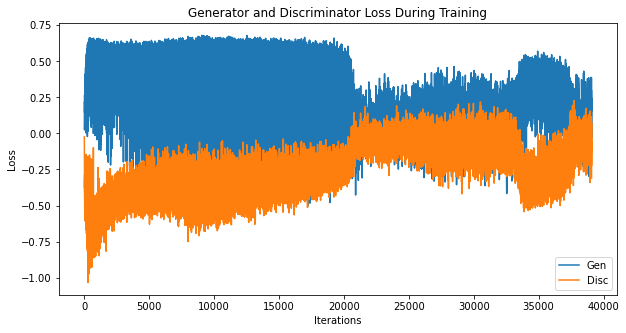

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss,label="Gen")
plt.plot(DiscLoss,label="Disc")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
np.mean(GenLoss),np.mean(DiscLoss)

(0.26496997, -0.25862896)

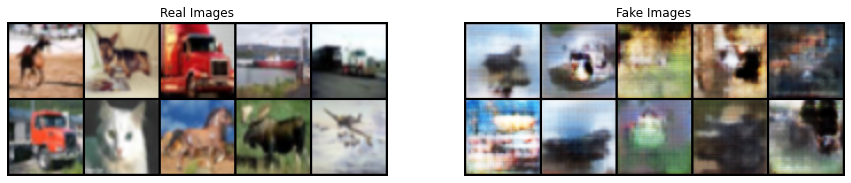

In [14]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10],nrow=5, padding=2, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(utils.make_grid(img_list[-1].to(device),nrow=5, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


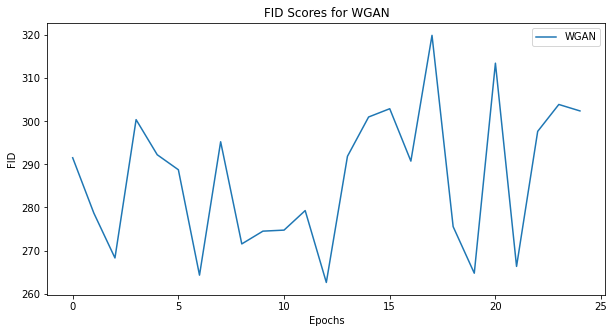

In [15]:
plt.figure(figsize=(10,5))
plt.title("FID Scores for WGAN")
plt.plot(FID_list,label="WGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.show()

In [16]:
np.mean(FID_list), FID_list[-1]

(286.9072314139566, 302.41367329856917)